Toggle Code

# Number of Extreme Speeding Vehicles by DoW ToD 

### 1. Major Mackenzie Drive West btwn Sir Benson Drive & Thomas Cook Avenue

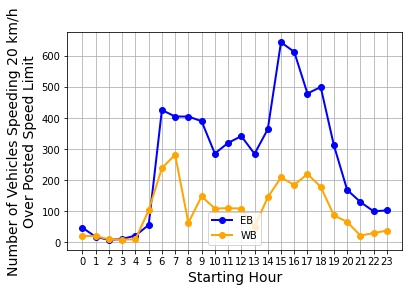

In [1]:

from IPython.display import display_html
display_html("""<button onclick="$('.input, .prompt, .output_stderr, .output_error').toggle();">Toggle Code</button>""", raw=True)


import pyodbc
import pandas as pd
import numpy as np
from IPython.display import Markdown

from pandas import DataFrame
import matplotlib.pyplot as plt

import program_configs as config

def build_dbquery_for_speeding(geoid,stddat,bdir):
    db_query=""
    #if any argument is empty, return empty string
    if (geoid is None) or (stddat is None) or (bdir is None):
        return db_query 
    #if it's for an ew street
    elif bdir=="ew":

        db_query=f"select spdtab.studydate,spdtab.dow,spdtab.hourid\
        ,spdtab.eb_avgspd,spdtab.wb_avgspd,spdtab.avgspd\
        ,spdtab.eb_vehvol_ncomp4,spdtab.wb_vehvol_ncomp4\
        ,spdtab.eb_vehvol,spdtab.wb_vehvol\
        ,spdtab.vehvol_ncomp4,spdtab.vehvol\
        from studydata.spdstd_60min_latest_wide spdtab\
            where spdtab.LOCATIONID='{geoid}'\
                and spdtab.studydate='{stddat}'\
                order by spdtab.hourid;"
    #if it's for an ns street
    elif bdir=="ns":

        db_query=f"select spdtab.studydate,spdtab.dow,spdtab.hourid\
        ,spdtab.nb_avgspd,spdtab.sb_avgspd,spdtab.avgspd\
        ,spdtab.nb_vehvol_ncomp4,spdtab.sb_vehvol_ncomp4\
        ,spdtab.nb_vehvol,spdtab.sb_vehvol\
        ,spdtab.vehvol_ncomp4,spdtab.vehvol\
        from studydata.spdstd_60min_latest_wide spdtab\
            where spdtab.LOCATIONID='{geoid}'\
                and spdtab.studydate='{stddat}'\
                order by spdtab.hourid;"
        
     
    return db_query
        
#open the input and output csv files
try:
    roads_list = pd.read_csv(config.roads_info)
except Exception as e:
    print("Can't read roads_info file.")

conn = pyodbc.connect(config.conn_str)

display(Markdown("""# Number of Extreme Speeding Vehicles by DoW ToD """))

for ind in roads_list.index:
    #print(type(roads_list['pspl'][ind]))
    my_query=build_dbquery_for_speeding(roads_list['geoid'][ind],roads_list['studydat'][ind],roads_list['bdir'][ind]) 
    if len(my_query)<2:
        continue
    result_from_db=conn.execute(my_query)
    df = DataFrame.from_records(result_from_db.fetchall(),columns=[x[0] for x in result_from_db.description])
    #print(len(df))
    
    display(Markdown('### %s' % roads_list['loc_desc'][ind]))
    
    # create figure and axis objects with subplots()
    fig,ax = plt.subplots()
    
    # make a plot
    if roads_list['bdir'][ind]=="ew":
        l1,=ax.plot(df.hourid,df.eb_vehvol_ncomp4,color='blue', linewidth=2, linestyle='solid',marker="o")
        l2,=ax.plot(df.hourid,df.wb_vehvol_ncomp4,color='orange', linewidth=2, linestyle='solid',marker="o")
    
        plt.legend(handles=[l1,l2],labels=['EB','WB'],loc='lower center')
    
    if roads_list['bdir'][ind]=="ns":
        l1,=ax.plot(df.hourid,df.nb_vehvol_ncomp4,color='blue', linewidth=2, linestyle='solid',marker="o")
        l2,=ax.plot(df.hourid,df.sb_vehvol_ncomp4,color='orange', linewidth=2, linestyle='solid',marker="o")
    
        plt.legend(handles=[l1,l2],labels=['NB','SB'],loc='lower center')
    
    # set x-axis label
    ax.set_xlabel("Starting Hour", fontsize=14)
    # set y-axis label
    ax.set_ylabel("Number of Vehicles Speeding 20 km/h\nOver Posted Speed Limit",fontsize=14)
  
    
    plt.xticks(df.hourid)
    plt.grid(True)
        
    plt.show()
        
   
    #fig.savefig(config.chart_out_dir+(roads_list['loc_desc'][ind])[0:5]+'.jpg',\
    #        format='jpeg',\
    #        dpi=100,\
    #        bbox_inches='tight')
   